# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm #Это прогресс показываем
from scipy.optimize import minimize
from sklearn.datasets import load_boston, make_moons
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
import warnings
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
warnings.filterwarnings('ignore')

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1, fixed_gamma=0):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.gammas = []
        self.fixed_gamma = fixed_gamma
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        #init
        y_new = np.zeros(y.shape)
        #let's go
        if self.fixed_gamma == 0:
            for i in range(self.n_estimators):
                y_new += self.learning_rate * self.find_best_gamma(y_new, x, y)
        else:
            for i in range(self.n_estimators):
                y_new += self.learning_rate * self._fit_predict_tree(x, y - y_new)

    def find_best_gamma(self, y_old, x, y_true):
        prediction = self._fit_predict_tree(x, y_true - y_old)
        gamma = minimize(lambda x: mean_squared_error(y_true - y_old, x * prediction), 0.5).x
        self.gammas.append(*gamma)
        return gamma * prediction
   
    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return tree.predict(x) #Убрал lr, gamma потому что надо подгонять гамму каждый шаг
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(x.shape[0])
        if self.fixed_gamma == 0:
            for i in range(self.n_estimators):
                y_pred += self.trees[i].predict(x) * self.gammas[i] * self.learning_rate
        else:
            for i in range(self.n_estimators):
                y_pred += self.trees[i].predict(x) * self.learning_rate
        return y_pred
    
    def get_info(self):
        return {"n_estimators":self.n_estimators, 
                "max_depth":self.max_depth, 
                "learning_rate":self.learning_rate,
                "fixed_gamma":self.fixed_gamma}
    
    def get_gammas(self):
        return self.gammas

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [3]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [5]:
np.random.seed(19052019)
n = np.arange(5, 200, 5)
md = np.arange(4, 10, 1)
lr = np.arange(0.05, 1.01, 0.05)
best = np.inf
for i in tqdm(n):
    for j in md:
        for k in lr:
            gb = GradientBoosting(i, j, k, 0)
            gb.fit(X_train, y_train)
            mse = mean_squared_error(y_test, gb.predict(X_test))
            if mse < best:
                best = mse
                params = gb.get_info() #Модель ставить не стоит, потому что питон же будет и её обновлять (указатели)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [19:11<00:00, 29.53s/it]


In [6]:
print(params, "\n", best)

{'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.3, 'fixed_gamma': 0} 
 9.07223755821884


In [7]:
np.random.seed(19052019)
n = np.arange(5, 200, 5)
md = np.arange(4, 10, 1)
lr = np.arange(0.05, 1.01, 0.05)
best = np.inf
for i in tqdm(n):
    for j in md:
        for k in lr:
            gb = GradientBoosting(i, j, k, 1)
            gb.fit(X_train, y_train)
            mse = mean_squared_error(y_test, gb.predict(X_test))
            if mse < best:
                best = mse
                params = gb.get_info()

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [09:32<00:00, 14.69s/it]


In [8]:
print(params, "\n", best)

{'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.3, 'fixed_gamma': 1} 
 9.129645870984007


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да 

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [9]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [10]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
# Референс

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier(verbosity=0)
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.6957629249683959

In [12]:
train["DayOfWeek"] = train["DayOfWeek"].map(lambda x: "DOW" + x[-1]) #Потому что иначе названия 1 в 1 с месяцами
train["Origin"] = train["Origin"].map(lambda x: "O" + x)
train["Dest"] = train["Dest"].map(lambda x: "D" + x)
train["DayofMonth"] = train["DayofMonth"].map(lambda x: "DM" + x)

for i in ["DayOfWeek", "UniqueCarrier", "Origin", "Dest", "Month", "DayofMonth"]:
    temp = pd.get_dummies(train[i])
    train = pd.concat([train, temp], axis=1)
    train = train.drop(i, axis = 1)

y_train = train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
train = train.drop("dep_delayed_15min", axis = 1)
X_train = train.values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

cat = CatBoostClassifier(silent=True, iterations=3500)
cat.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, cat.predict_proba(X_valid)[:, 1])

# тест тут видимо отдыхает?

0.7512377333066756

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [13]:
# Рекомендации -- это только рекомендации
# И это прекрасно!
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.ms = min_samples

    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        
        # Инициализируем классы большим красивым нан
        self.clusters = np.full(X.shape[0], None)
        n = 1
        # Сделаем сразу для всех и задешево, нампи явно быстрее вызова функции каждый раз
        self.dist = np.linalg.norm(np.tile(X, X.shape[0]).reshape(X.shape[0], X.shape[0], X.shape[1]) - X, axis = -1)
        for i in range(X.shape[0]):
            if self.clusters[i] == None:  
                self.grow_cluster(n, i)
                n += 1
        # Вынесем шум в отдельный класс
        un, rc = np.unique(self.clusters, return_counts = True)
        for i in un[rc == 1]:
            self.clusters[self.clusters == i] = 0
        
        return self.clusters
    
    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        self.clusters[neighbours] = root
        inmates = np.where([(self.dist[neighbours] < self.eps)])[1]
        if inmates.shape[0] >= self.ms:
            for i in inmates:   
                if self.clusters[i] == None:
                    self.grow_cluster(root, i)
        

Проверим себя на простом примере:

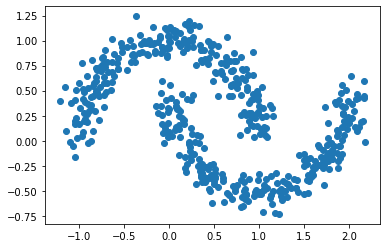

In [14]:
X, _ = make_moons(n_samples=500, noise=0.1, random_state=42)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

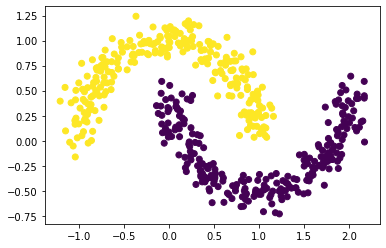

In [15]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

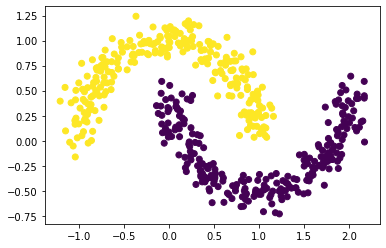

In [16]:
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

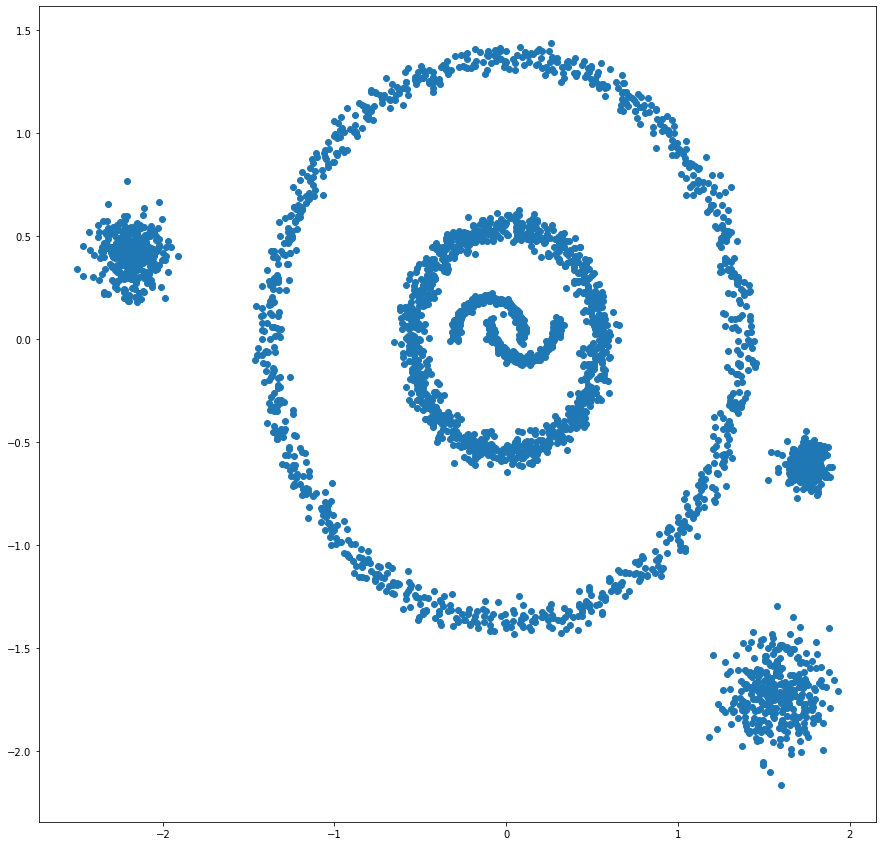

In [17]:
# Сделаем кружочки с лунами и блобами
n_samples = 2000
plt.figure(figsize=(15,15))
noisy_circles, _ = datasets.make_circles(n_samples=n_samples, factor=.4,
                                      noise=.03)
noisy_circles[:, 0] *= 1.37
noisy_circles[:, 1] *= 1.37

noisy_moons, _ = datasets.make_moons(n_samples=n_samples//5, noise=.07)

noisy_moons[:, 0] *= 0.2
noisy_moons[:, 0] -= 0.1
noisy_moons[:, 1] *= 0.2

varied, _ = datasets.make_blobs(n_samples=n_samples//2,
                             cluster_std=[0.35, 0.25, 0.15],
                             random_state=123)
varied[:,0] *= 0.4
varied[:,1] *= 0.4
X = np.vstack((noisy_circles, noisy_moons))
X = np.vstack((X, varied))
plt.scatter(X[:,0], X[:,1])

Или хотя бы что-нибудь такое: 

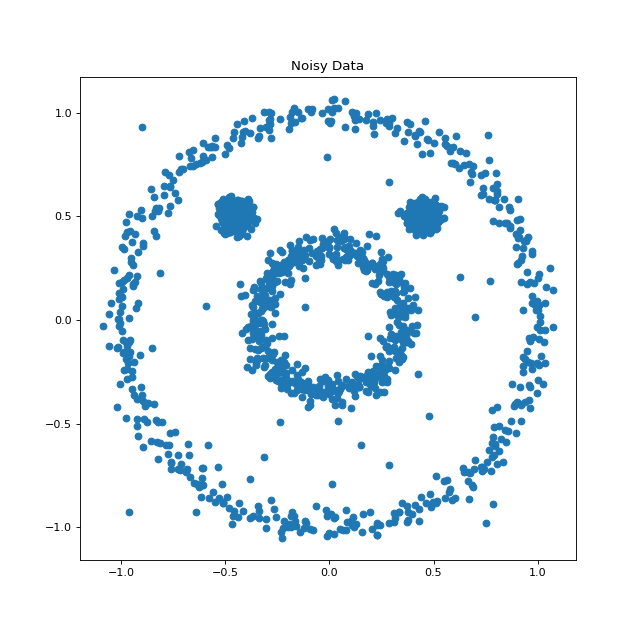

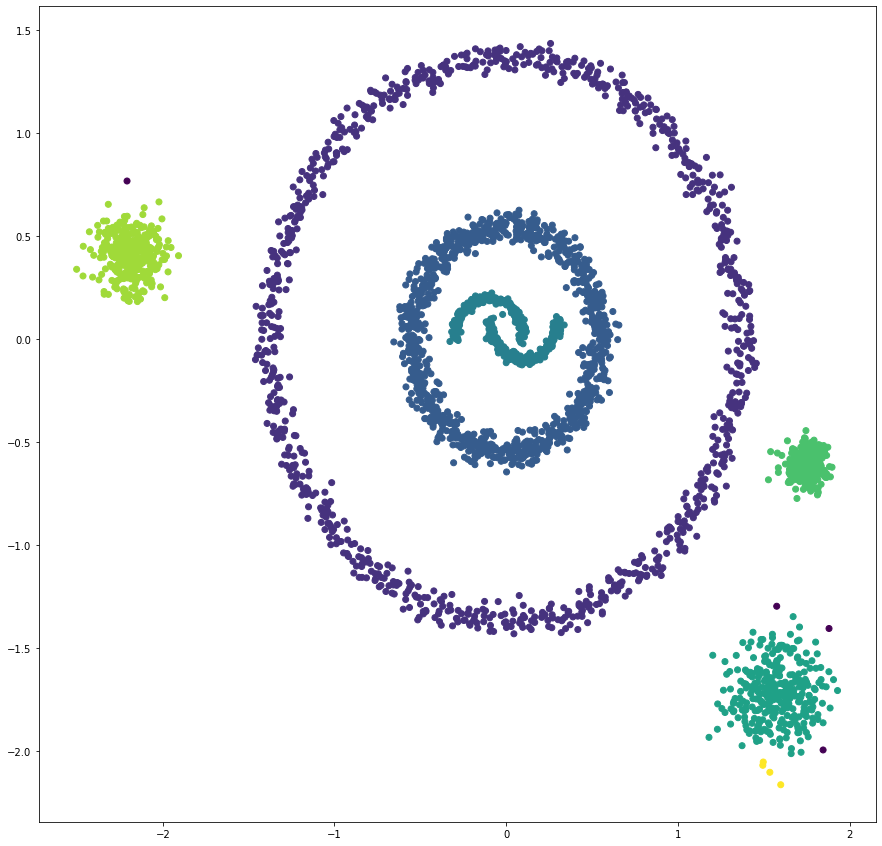

In [18]:
plt.figure(figsize=(15,15))
clusters = DBSCAN(eps=0.1, min_samples=2).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)

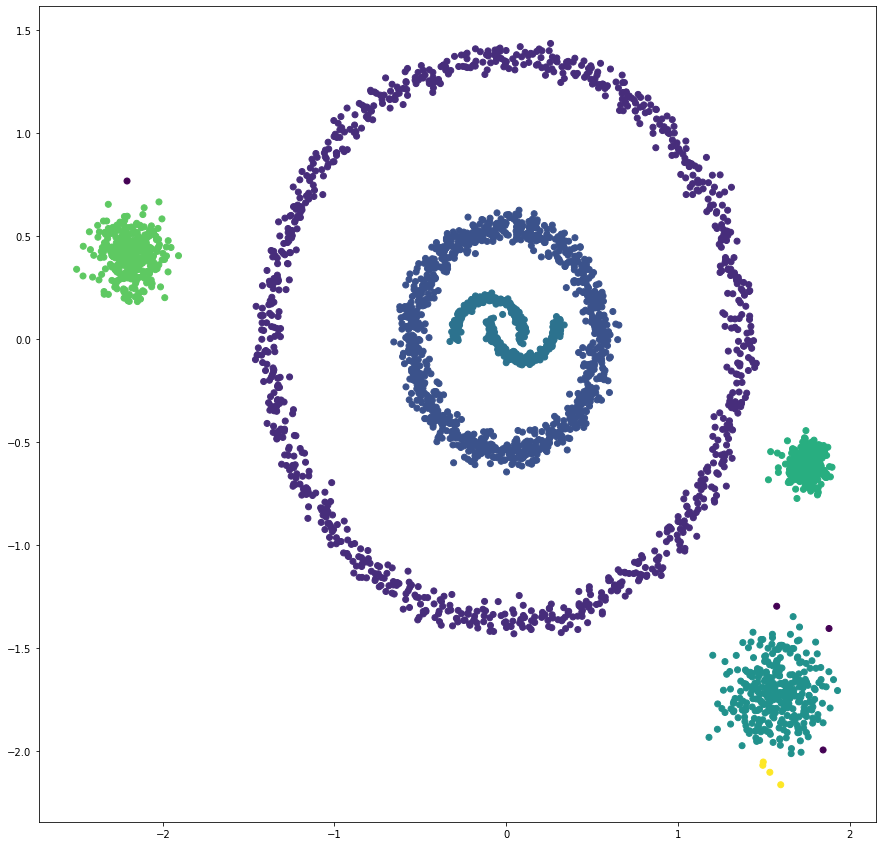

In [19]:
plt.figure(figsize=(15,15))
clusters = dbscan(eps=0.1, min_samples=2).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [20]:
%%timeit
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

21.7 ms ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

405 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
